# OGM-G Example

## Import the required libraries

In [ ]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import itertools
import functools
from IPython.display import display

## Define the functions

In [2]:
L = pf.Parameter("L")
f = pf.SmoothConvexFunction(is_basis=True, tags=["f"], L=L)

## Write a function to return the PEPContext associated with OGM-G

In [3]:
@functools.cache
def theta(i, N):
    if i == -1:
        return 0
    if i == N:
        return 1 / sp.S(2) * (sp.S(1) + sp.sqrt(8 * theta(N - 1, N) ** 2 + sp.S(1)))
    return 1 / sp.S(2) * (sp.S(1) + sp.sqrt(4 * theta(i - 1, N) ** 2 + sp.S(1)))


def reverse_theta(i, N):
    return theta(N - i, N)

In [4]:
def make_ctx_ogm_g(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_ogm_g = pf.PEPContext(ctx_name).set_as_current()
    x = pf.Vector(is_basis=True, tags=["x_0"])
    z = x
    z = z - stepsize * (reverse_theta(0, N) + 1) / 2 * f.grad(x)
    z.add_tag(f"z_{1}")
    f.set_stationary_point("x_star")
    for i in range(1, N + 1):
        y = x - stepsize * f.grad(x)
        x = (reverse_theta(i + 1, N) / reverse_theta(i, N)) ** 4 * y + (
            1 - (reverse_theta(i + 1, N) / reverse_theta(i, N)) ** 4
        ) * z
        x.add_tag(f"x_{i}")

        z = z - stepsize * reverse_theta(i, N) * f.grad(x)
        z.add_tag(f"z_{i + 1}")
    return ctx_ogm_g

## Numerical evidence of convergence of OGM-G

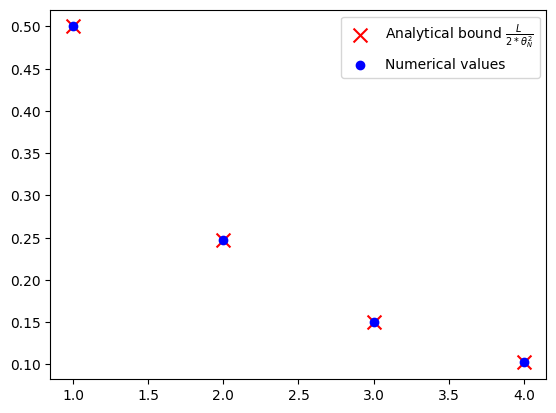

In [5]:
N = 5
R = pf.Parameter("R")
L_value = 1
R_value = 1

opt_values = []
for k in range(1, N):
    ctx_plt = make_ctx_ogm_g(ctx_name=f"ctx_plt_{k}", N=k, stepsize=1 / L)
    pb_plt = pf.PEPBuilder(ctx_plt)
    pb_plt.add_initial_constraint(
        (f(ctx_plt["x_0"]) - f(ctx_plt["x_star"])).le(R, name="initial_condition")
    )
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric((f.grad(x_k)) ** 2)
    result = pb_plt.solve(resolve_parameters={"L": L_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N)
analytical_values = [2 * L_value / reverse_theta(0, i) ** 2 for i in iters]
plt.scatter(
    iters,
    analytical_values,
    color="red",
    marker="x",
    s=100,
    label="Analytical bound $\\frac{L}{2*\\theta_N^2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of OGM-G

In [6]:
N = 2

ctx_prf = make_ctx_ogm_g(ctx_name="ctx_prf", N=N, stepsize=1 / L)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    (f(ctx_prf["x_0"]) - f(ctx_prf["x_star"])).le(R, name="initial_condition")
)
pb_prf.set_performance_metric((f.grad(ctx_prf[f"x_{N}"])) ** 2)

result = pb_prf.solve(resolve_parameters={"L": L_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(f)

0.2475766627276036


In [7]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"L": L_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


- It turns out for OGM no further relaxation is needed. Now we store the results.

In [8]:
# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of f
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(f)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

In [9]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

- Print the values of $\lambda$ obtained from the solver

In [10]:
lamb_sol.pprint()

<IPython.core.display.Math object>

- Consider proper candidate of closed form expression of $\lambda$

In [11]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if i == N:  # Additional constraint 1 (between x_★)
        if j == 0:
            return 1 / reverse_theta(1, N) ** 2 - 2 / reverse_theta(0, N) ** 2
        elif j < N:
            return 1 / reverse_theta(j + 1, N) ** 2 - 1 / reverse_theta(j, N) ** 2
        elif j == N:
            return 1 - lamb(f"x_{N - 1}", f"x_{N}")
    if i < N and i + 1 == j:  # Additional constraint 2 (consecutive)
        return 1 / reverse_theta(i + 1, N) ** 2
    if i == N and j == N + 1:
        return 2 / reverse_theta(0, N) ** 2
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [12]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-4),
)

Did we guess the right closed form of lambda? True


### Closed form expression of $S$

In [13]:
S_sol.pprint()

<IPython.core.display.Math object>

- Interestestingly, $S$ has a rank of 0.

In [14]:
rank = np.linalg.matrix_rank(np.round(S_sol.matrix, 3))
print(rank)

0


### Symbolic calculation

- Assemble the RHS of the proof.

In [29]:
interp_scalar_sum = pf.Scalar.zero()
for x_i, x_j in itertools.product(ctx_prf.tracked_point(f), ctx_prf.tracked_point(f)):
    if lamb(x_i.tag, x_j.tag) != 0:
        interp_scalar_sum += lamb(x_i.tag, x_j.tag) * f.interp_ineq(x_i.tag, x_j.tag)

display(interp_scalar_sum)

0+(1/2 + sqrt(5)/2)**(-2)*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+1*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+-2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + (1/2 + sqrt(5)/2)**(-2)*(f(x_0)-f(x_2)+grad_f(x_0)*(x_2-x_0)+1/2*L*|grad_f(x_2)-grad_f(x_0)|^2)+1 - 1/(1/2 + sqrt(5)/2)**2*(f(x_1)-f(x_2)+grad_f(x_1)*(x_2-(x_1))+1/2*L*|grad_f(x_2)-grad_f(x_1)|^2)+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_star)-f(x_2)+grad_f(x_star)*(x_2-x_star)+1/2*L*|grad_f(x_2)-grad_f(x_star)|^2)

In [30]:
RHS = interp_scalar_sum
display(RHS)

0+(1/2 + sqrt(5)/2)**(-2)*(f(x_1)-f(x_0)+grad_f(x_1)*(x_0-(x_1))+1/2*L*|grad_f(x_0)-grad_f(x_1)|^2)+1*(f(x_2)-f(x_1)+grad_f(x_2)*(x_1-(x_2))+1/2*L*|grad_f(x_1)-grad_f(x_2)|^2)+-2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2 + (1/2 + sqrt(5)/2)**(-2)*(f(x_0)-f(x_2)+grad_f(x_0)*(x_2-x_0)+1/2*L*|grad_f(x_2)-grad_f(x_0)|^2)+1 - 1/(1/2 + sqrt(5)/2)**2*(f(x_1)-f(x_2)+grad_f(x_1)*(x_2-(x_1))+1/2*L*|grad_f(x_2)-grad_f(x_1)|^2)+2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_star)-f(x_2)+grad_f(x_star)*(x_2-x_star)+1/2*L*|grad_f(x_2)-grad_f(x_star)|^2)

- Assemble the LHS of the proof

In [32]:
x_0 = ctx_prf["x_0"]
x_N = ctx_prf[f"x_{N}"]
x_star = ctx_prf["x_star"]
LHS = 1 / L * (f.grad(x_N)) ** 2 - (2 / reverse_theta(0, N) ** 2) * (f(x_0) - f(x_star))
display(LHS)

1/L*|grad_f(x_2)|^2-2/(1/2 + sqrt(1 + 8*(1/2 + sqrt(5)/2)**2)/2)**2*(f(x_0)-f(x_star))

In [ ]:
diff = LHS - RHS
display(diff)

In [33]:
pf.pprint_str(
    diff.repr_by_basis(ctx_prf, sympy_mode=True, resolve_parameters={"L": sp.S("L")})
)

<IPython.core.display.Math object>